In [1]:
import gym
from gym import spaces
from stable_baselines3 import PPO, DQN, A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
import numpy as np
import random
from shapely.geometry import Polygon,Point
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Util functions for input data


In [2]:
sting = '103.9184733 1.3092462, 103.9185355 1.3092515, 103.9185338 1.3092714, 103.9186415 1.3092804, 103.9186431 1.3092613, 103.9187158 1.3092674, 103.9187202 1.3092156, 103.9187321 1.3092166, 103.9187379 1.3091466, 103.9186642 1.3091404, 103.9186697 1.3090749, 103.9187467 1.3090814, 103.9187526 1.3090106, 103.9187395 1.3090095, 103.9187444 1.3089509, 103.9186749 1.3089451, 103.9186763 1.3089285, 103.9185696 1.3089195, 103.9185683 1.3089349, 103.9185011 1.3089292, 103.9184967 1.3089811, 103.9184756 1.3089793, 103.9184691 1.3090564, 103.918545 1.3090628, 103.9185392 1.3091312, 103.9184654 1.3091249, 103.9184593 1.3091968, 103.9184773 1.3091984, 103.9184733 1.3092462'
#replace "' "with ","
sting = sting.replace(", ",",")

string_list = sting.split(",")
# print(string_list)
string_list = ["("+ string_list[i].replace(" ",",") + ")" for i in range(len(string_list))]

string = "("+ ",".join(string_list) + ")"
# print(string)

/Users/jefflai/SpaDS/env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jefflai/SpaDS/env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jefflai/SpaDS/env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jefflai/SpaDS/env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: Matplotli

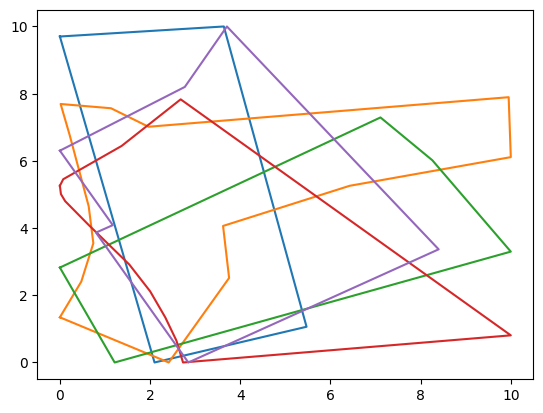

In [2]:
sites_list = [Polygon(((103.9367259,1.3143551),(103.9370357,1.3129232),(103.9375333,1.3130801),(103.9372625,1.3143992),(103.9367259,1.3143551))),
              Polygon(((103.8272847,1.2843737),(103.8277838,1.2840957),(103.8280608,1.2846159),(103.8280331,1.2849361),(103.8286137,1.2851832),(103.8293528,1.2853596),(103.829343,1.2857285),(103.8276913,1.2855466),(103.827519,1.2856605),(103.8272881,1.2856867),(103.8273295,1.2854956),(103.8274168,1.2850571),(103.8274381,1.2848296),(103.8273828,1.2845934),(103.8272847,1.2843737))),
            Polygon(((103.9502369,1.3283904),(103.9505232,1.3277247),(103.9525938,1.3285024),(103.9521837,1.3291431),(103.9519125,1.3294435),(103.9502369,1.3283904))),
             Polygon(((103.9347477,1.3384172),(103.9347544,1.3383448),(103.9347819,1.3382832),(103.9349328,1.338078),(103.935199,1.3377301),(103.9353338,1.3374975),(103.9354324,1.3372696),(103.9355048,1.3370671),(103.9355476,1.3368769),(103.9376767,1.3371135),(103.9355323,1.3391707),(103.9351487,1.3387645),(103.9347692,1.3384742),(103.9347477,1.3384172))),
             Polygon(((103.9544223,1.3204243),(103.9545532,1.3201771),(103.9545116,1.3201523),(103.9547401,1.3197211),(103.9553594,1.3200968),(103.9548355,1.3208367),(103.9547314,1.320636),(103.9544223,1.3204243)))]#plot pologon

def resize_polygon(site,desired_scale  =10):
    X,Y = site.exterior.xy
    # scale x,y so that it is between 0to 10 range 

    # Calculate the scale factor to fit the polygon within a specific range
    current_width = max(X) - min(X)
    current_height = max(Y) - min(Y)

    longest_axis = max(current_width, current_height)
    scale_factor = desired_scale /longest_axis


    # Scale the polygon coordinates
    scaled_polygon_x = [(x- min(X)) * scale_factor  for x in X]
    scaled_polygon_y = [(y-min(Y)) * scale_factor  for y in Y]

    return scaled_polygon_x, scaled_polygon_y

fig, ax = plt.subplots()
for site in sites_list:
    X,Y = resize_polygon(site)

    ax.plot(X,Y)

plt.show()

# RL Class


In [8]:
class SpaDesPlacement(gym.Env):
    def __init__(self,sites_list, grid_size=(10, 10), max_buildings=10, site_coverage= 0.15, building_offset = 0.5):
        super(SpaDesPlacement, self).__init__()
        self.grid_size = grid_size
        self.grid= np.zeros(self.grid_size, dtype=int)
        self.max_buildings = max_buildings
        self.site_coverage = site_coverage
        self.sites_list = sites_list
        self.site_boundary = self._generate_site(self.sites_list)
        self.building_list = [Polygon(((103.9182582,1.3085852),(103.9183205,1.3085905),(103.9183188,1.3086104),(103.9184265,1.3086194),(103.9184281,1.3086003),(103.9185008,1.3086064),(103.9185052,1.3085546),(103.918517,1.3085556),(103.9185229,1.3084856),(103.9184491,1.3084794),(103.9184547,1.3084139),(103.9185317,1.3084204),(103.9185376,1.3083497),(103.9185245,1.3083486),(103.9185294,1.30829),(103.9184599,1.3082841),(103.9184613,1.3082676),(103.9183545,1.3082586),(103.9183532,1.3082739),(103.9182861,1.3082683),(103.9182817,1.3083201),(103.9182606,1.3083183),(103.9182541,1.3083954),(103.91833,1.3084018),(103.9183242,1.3084702),(103.9182504,1.308464),(103.9182443,1.3085359),(103.9182623,1.3085374),(103.9182582,1.3085852))),
                              Polygon(((103.9180943,1.309182),(103.9182393,1.3091933),(103.9182464,1.3091028),(103.9182956,1.3091066),(103.9183064,1.308967),(103.9181121,1.3089519),(103.9180943,1.309182))),
                              Polygon(((103.9184733,1.3092462),(103.9185355,1.3092515),(103.9185338,1.3092714),(103.9186415,1.3092804),(103.9186431,1.3092613),(103.9187158,1.3092674),(103.9187202,1.3092156),(103.9187321,1.3092166),(103.9187379,1.3091466),(103.9186642,1.3091404),(103.9186697,1.3090749),(103.9187467,1.3090814),(103.9187526,1.3090106),(103.9187395,1.3090095),(103.9187444,1.3089509),(103.9186749,1.3089451),(103.9186763,1.3089285),(103.9185696,1.3089195),(103.9185683,1.3089349),(103.9185011,1.3089292),(103.9184967,1.3089811),(103.9184756,1.3089793),(103.9184691,1.3090564),(103.918545,1.3090628),(103.9185392,1.3091312),(103.9184654,1.3091249),(103.9184593,1.3091968),(103.9184773,1.3091984),(103.9184733,1.3092462)))]
        # self.building_list = [Polygon(zip(*self._resize_polygon(building,2))) for building in self.building_list]
    
        # Define the action space for continuous placement (x, y, ind, height)
        self.action_space = spaces.Box(low=np.array([0,0,0,1]), high=np.array([1,1,1,9]), shape=(4,), dtype=np.float64)

        # Define the state space to represent the current box positions and sizes
        
        space = {'grid' :spaces.MultiBinary(np.prod(grid_size)+ max_buildings), #building location
                #  'site_boundary' : spaces.Box(0,grid_size[0], shape=(2,50)),
                #   'site_coverage' : spaces.Box(0,1,shape=(1,1)),                 
                #   'buildings_polygon':spaces.Box(0,grid_size[0], shape=(2,50*max_buildings)),
                #   'buildings_ind':spaces.Box(0,np.prod(grid_size), shape=(max_buildings,))
                  }
        
        # self.observation_space = spaces.Dict(space)
        self.observation_space = spaces.MultiBinary(np.prod(grid_size)+ max_buildings)
        self.boxes_placed = 0
        self.buildings =[]
        self.buildings_ind = np.zeros(max_buildings)
        
        
        self.state = self._get_state()
        self.building_offset = building_offset

    def reset(self, sites_list=sites_list, site_coverage= 0.5):
        self.boxes_placed = 0
        self.site_boundary = self._generate_site(sites_list)
        self.buildings = []
        self.buildings_ind = np.zeros(self.max_buildings)
        self.grid = np.zeros(self.grid_size)
        self.site_coverage = site_coverage
        self.state = self._get_state()
        return self.state

    def step(self, action):
        # Execute an action (place a box) and return the next state, reward, and done flag
        if self.boxes_placed >= self.max_buildings:
            return self.state, -1, True, {}
        
        if not self._is_valid_site_coverage():
            return self.state, -1, True, {}
        
        

        x, y,ind, height = action
        
        x,y,ind,height = math.floor(x*9.8),math.floor(y*9.8), math.floor(ind*len(self.building_list)*0.98), int(height)
        print(x,y,ind,height)
        building = self._get_building(ind,(x,y))
        if not self.site_boundary.contains(building):
            return self.state, -1, False, {}

        if not self._is_valid_placement(building):
            return self.state, -1, False, {}
        self.buildings_ind[self.boxes_placed] = y * self.grid_size[0] + x
        self.buildings.append(building)
        self.boxes_placed += 1
        self.grid[x,y] = 1 
        self.state = self._get_state()
        print(self.state)

        reward = 1

        done = self.boxes_placed >= self.max_buildings

        return self.state, reward, done, {}
    def _get_building(self, ind,center):
        ind = int(ind)
        x,y = self._resize_polygon(self.building_list[ind],2,center)
        return Polygon(zip(x,y))

    def _is_valid_placement(self, building):
        # Check if the placement is valid (no intersection with other boxes)
        
        for i in range(self.boxes_placed):
            
            # x,y,ind,_ = self.building_list[i]
            # building1 = self._get_building(int(ind),(x, y))
            building1 = self.buildings[i]
            
            if ( building.intersects(building1)
                ):
                # if buildings intersected
                return False
        self.render1(building)

        return True
    
   
    def _resize_polygon(self, site, desired_scale=10, center=None):
        X, Y = site.exterior.xy
        # print(site.exterior.xy)

        # Calculate the center of the polygon if a custom center is not provided
        

        # Calculate the scale factor to fit the polygon within a specific range
        current_width = max(X) - min(X)
        current_height = max(Y) - min(Y)
        # print(current_width, current_height)
        longest_axis = max(current_width, current_height)
        scale_factor = desired_scale / longest_axis

        if center is None:
            center_x = current_width / 2
            center_y = current_height / 2
        else:
            center_x, center_y = center

        # Scale and center the polygon coordinates
        scaled_polygon_x = [(x - min(X)) * scale_factor + center_x for x in X]
        scaled_polygon_y = [(y - min(Y)) * scale_factor + center_y for y in Y]

        return scaled_polygon_x, scaled_polygon_y


    def _get_state(self):
        
        box_count = np.zeros(self.max_buildings)
        box_count[:self.boxes_placed] = 1

        def pad_polygon(polygon, target_length):
            current_length = len(polygon.exterior.xy[0])
            
            # Pad with zeros if the polygon has fewer vertices than the target length
            padding_length = max(0, target_length - current_length)
            padded_vertices_x = list(polygon.exterior.xy[0]) + [0] * padding_length
            padded_vertices_y = list(polygon.exterior.xy[1]) + [0] * padding_length
            
            return np.array([padded_vertices_x, padded_vertices_y])
        
        site_boundary = pad_polygon(self.site_boundary, 50)

        padded_buildings= []

        # Pad each polygon and append to the list
        for poly in self.buildings:
            padded_building = pad_polygon(poly, target_length=50)
            padded_buildings.append(padded_building)
        if len(padded_buildings) < self.max_buildings:
            remaining_buildings = self.max_buildings - len(padded_buildings)
            for _ in range(remaining_buildings):
                padded_buildings.append(np.zeros((2, 50)))

        # Create a Tuple from the list of padded observations
        buildings = np.concatenate(padded_buildings, axis=1)



        space = {'grid' :np.concatenate([self.grid.flatten(), box_count]) #self.grid.flatten(), #building location
                #   'site_boundary': site_boundary,
                #   'site_coverage':np.array([self.site_coverage]).reshape((1, 1)),
                #   'buildings_polygon':buildings,
                #   'buildings_ind':self.buildings_ind
                }
        
        return np.concatenate([self.grid.flatten(), box_count])
    
    def _is_valid_site_coverage(self):
        total_footprint = 0
        for i in range(self.boxes_placed):
           
            building = self.buildings[i]
            
            total_footprint += building.area
            
        if (total_footprint/self.site_boundary.area > self.site_coverage):
            # print('total_footprint > site_coverage: ', total_footprint/np.prod(self.grid_size))
            

            return False
        
    
        
        return True
    
    def _generate_site(self,sites_list, center = None):
        site = sites_list[random.randint(0,len(sites_list)-1)]
        x,y =  self._resize_polygon(site)
        return Polygon(list(zip(x, y)))
    
    def render(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Create vertices for the building
        for i in range(len(self.buildings)):
            # print(self.boxes[i])
            # x,y,ind,height = self.boxes[i]
            # building = self._get_building(int(ind),(x, y))
            # print(building)
            building = self.buildings[i]
            def extrude_polygon(polygon, height):
                # Create a prism by extruding the polygon in the z-axis
                vertices = list(polygon.exterior.coords)
                prism_vertices = [(*point, 0) for point in vertices] + [(*point, height) for point in vertices]
                return prism_vertices
            
            prism_vertices = extrude_polygon(building, 1)
            ax.add_collection3d(Poly3DCollection([prism_vertices], alpha=0.25, linewidths=1, edgecolors='r'))

        # Set axis labels
        ax.plot(list(self.site_boundary.exterior.xy[0]),list(self.site_boundary.exterior.xy[1])  , alpha=0.5)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        # Set plot limits
        ax.set_xlim([0, 10])
        ax.set_ylim([0, 10])
        ax.set_zlim([0, 10])

        # Display the plot
        plt.show()

    def render1(self,building):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Create vertices for the building
        
        def extrude_polygon(polygon, height):
            # Create a prism by extruding the polygon in the z-axis
            vertices = list(polygon.exterior.coords)
            prism_vertices = [(*point, 0) for point in vertices] + [(*point, height) for point in vertices]
            return prism_vertices
            
        prism_vertices = extrude_polygon(building, 1)
        ax.add_collection3d(Poly3DCollection([prism_vertices], alpha=0.25, linewidths=1, edgecolors='r'))

        # Set axis labels
        ax.plot(list(self.site_boundary.exterior.xy[0]),list(self.site_boundary.exterior.xy[1])  , alpha=0.5)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        # Set plot limits
        ax.set_xlim([0, 10])
        ax.set_ylim([0, 10])
        ax.set_zlim([0, 10])

        # Display the plot
        plt.show()


In [9]:
env = SpaDesPlacement(sites_list)
obs = env.reset()

# Sample action: (x, y, length, width, height)
action = np.array([0.5, 0.4, 1, 1])
obs, reward, done, _ = env.step(action)
print("Next state (box placement):")

4 3 2 1
Next state (box placement):


/Users/jefflai/SpaDS/env/lib/python3.11/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float64
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
4 0 0 1
2 0 1 1
0 0 2 1
0 9 2 1
0 5 0 1
0 0 0 2
2 3 2 1


/Users/jefflai/SpaDS/env/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


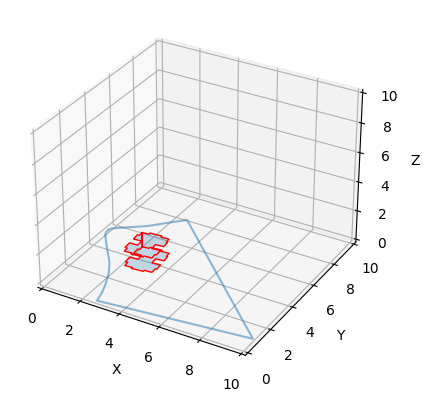

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 0 0 1
0 0 0 1
0 1 1 1
0 0 0 1
9 2 2 1
0 0 0 1
0 6 0 1
0 0 0 1
0 1 0 1
0 0 1 1
6 0 1 1
0 9 0 1
0 0 1 1
4 2 1 1


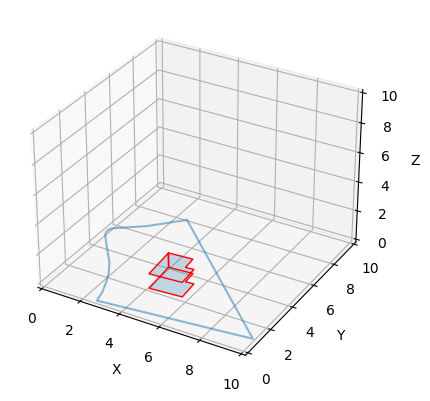

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
9 0 2 1
0 5 2 1
0 9 0 1
0 6 0 1
9 0 0 1
0 7 1 1
1 1 2 1
0 9 2 1
0 9 0 1
0 0 2 1
2 2 0 1
0 0 0 1
9 1 1 1
0 9 2 1
0 0 0 1
0 7 0 1
5 0 2 1
5 6 0 1
0 0 0 1
0 0 2 1
2 9 0 1
0 5 0 1
0 0 2 1
0 0 0 1
1 0 0 1
0 7 2 1
0 0 0 1
0 5 0 1
0 9 0 1
7 9 0 1
3 0 0 1
6 9 0 1
6 1 2 1


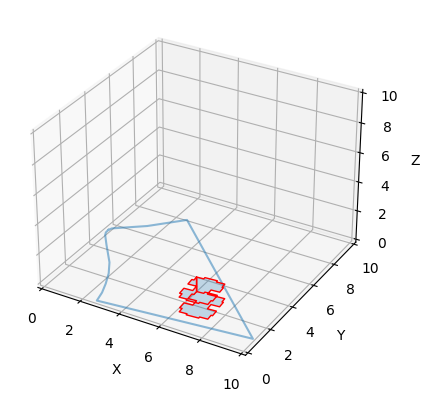

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
0 0 0 1
0 6 0 2
0 0 1 1
0 3 0 1
9 0 2 1
9 0 0 1
4 5 2 1
9 2 0 1
0 0 0 1
1 0 2 1
0 0 2 1
5 0 2 1
0 0 0 1
6 0 0 1
7 0 0 1
7 0 2 1
0 6 0 1
3 0 0 1
3 9 2 1
0 7 2 1
0 0 2 1
3 0 0 1
9 0 0 1
9 1 2 1
0 2 0 1
2 0 0 1
0 0 0 1
0 0 2 1
9 0 0 1
0 4 0 1
9 0 0 1
2 0 1 1
0 0 0 1
0 9 0 1
0 9 0 1
9 0 0 2
0 0 0 1
9 2 0 1
0 0 0 1
0 0 2 1
9 3 1 1
0 0 0 1
0 0 0 1
8 0 0 1
6 4 0 1
3 0 0 1
9 0 0 1
9 0 0 1
0 0 0 1
0 9 0 1
9 0 0 1
3 7 0 1
0 9 0 1
0 4 0 1
9 0 0 1
0 0 1 1
0 0 0 1
1 9 0 1
4 0 1 1
0 9 2 1
0 0 1 1
0 5 2 1
0 0 0 1
6 0 2 1
0 0 2 1
0 0 1 1
4 0 0 1
0 1 0 1
0 5 0 1
0 0 0 1
0 9 0 1
9 7 1 1
4 4 0 1
5 3 0 1
4 0 0 1
0 0 0 1
2 0 0 1
5 0 0 1
0 0 2 1
9 6 0 1
0 1 0 1
0 9 2 1
0 0 1 1


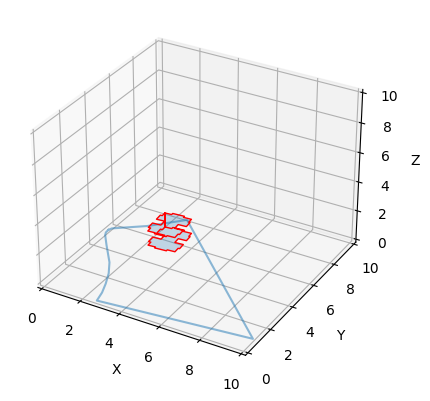

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
0 0 1 1
0 0 1 1
0 0 0 1
5 4 0 1
0 0 0 1
0 9 2 1
1 0 0 1
0 9 0 1
3 9 2 1
1 0 2 1
0 9 2 1
2 6 0 1
9 0 0 1
9 9 2 1
0 9 0 1
0 5 0 1
0 8 1 1
9 9 0 1
0 0 0 1
0 1 0 1
0 9 0 1
9 2 0 1
0 0 1 1
9 9 2 1
0 0 0 1
2 7 0 1
0 3 0 1
0 9 1 1
4 0 1 1
0 9 0 1
4 9 0 1
1 0 0 1
0 3 0 1
0 0 0 1
9 5 2 1
9 0 0 1
3 3 2 1
0 9 0 2
5 9 0 1
3 0 0 1
0 0 0 1
9 0 0 1
3 0 0 1
0 4 2 1
0 0 0 1
0 6 2 1
0 4 0 1
0 9 0 1
0 7 0 1
0 9 0 1
9 0 2 1
7 0 0 1
7 0 0 1
0 7 2 1
0 0 2 1
9 0 0 1
9 0 0 1
4 2 0 1
9 3 2 1
0 0 1 1
9 0 1 1
5 0 0 1
2 0 0 1
9 9 0 1
1 2 2 1
2 8 0 1
1 4 0 1
0 4 0 1
0 9 0 1
0 4 2 1
0 0 2 1
1 9 0 1
9 9 0 1
3 0 2 1
0 9 0 1
0 0 0 1
0 2 1 1
0 0 0 1
0 4 2 1
0 0 0 1
1 9 0 1
2 0 1 1
0 0 0 1


In [10]:
model = PPO('MlpPolicy', env, verbose=1)
# Train the agent
model.learn(total_timesteps=100000)

In [11]:
obs = env.reset()
# print(obs)
while True:
# for _ in range(1000):
    action, _ = model.predict(obs,deterministic=True)
    print(action)
    obs, _, done, _ = env.step(action)
    #reshpare a list to np.array (10x10)
    # env.render()
    if done:

        # print(np.array(obs[:100]).reshape(10,10))
        # print('boxes placed:\n ',env.boxes)
        # obs = env.reset()
        # print('done')
        break
env.render()

[0.         0.0363927  0.02035371 1.        ]
0 0 0 1
[0.         0.0363927  0.02035371 1.        ]
0 0 0 1
[0.         0.0363927  0.02035371 1.        ]
0 0 0 1
[0.         0.0363927  0.02035371 1.        ]
0 0 0 1
[0.         0.0363927  0.02035371 1.        ]
0 0 0 1
[0.         0.0363927  0.02035371 1.        ]
0 0 0 1
[0.         0.0363927  0.02035371 1.        ]
0 0 0 1
[0.         0.0363927  0.02035371 1.        ]
0 0 0 1
[0.         0.0363927  0.02035371 1.        ]
0 0 0 1
[0.         0.0363927  0.02035371 1.        ]
0 0 0 1
[0.         0.0363927  0.02035371 1.        ]
0 0 0 1
[0.         0.0363927  0.02035371 1.        ]
0 0 0 1
[0.         0.0363927  0.02035371 1.        ]
0 0 0 1
[0.         0.0363927  0.02035371 1.        ]
0 0 0 1
[0.         0.0363927  0.02035371 1.        ]
0 0 0 1
[0.         0.0363927  0.02035371 1.        ]
0 0 0 1
[0.         0.0363927  0.02035371 1.        ]
0 0 0 1
[0.         0.0363927  0.02035371 1.        ]
0 0 0 1
[0.         0.0363927  0.020

KeyboardInterrupt: 